In [9]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets

import utils.metrics
import utils.model

import models.mnist

In [18]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [34]:
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                             torchvision.transforms.RandomRotation(degrees=(0,0)),
                                             torchvision.transforms.ToTensor()])


data_train = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=True, transform=transforms)

train_set_size = int(len(data_train) * 0.9)
valid_set_size = len(data_train) - train_set_size
data_train, data_val = torch.utils.data.random_split(
    data_train, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(0))

data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=32,
                                                shuffle=True,
                                                )

transforms_test = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                             torchvision.transforms.RandomRotation(degrees=(0,0)),
                                             torchvision.transforms.ToTensor()])

data_loader_val = torch.utils.data.DataLoader(data_val,
                                               batch_size=32,
                                               shuffle=False)

data_test = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=False, transform=transforms_test)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=32,
                                               shuffle=False)

In [35]:
len(data_train), len(data_val), len(data_test)

(54000, 6000, 10000)

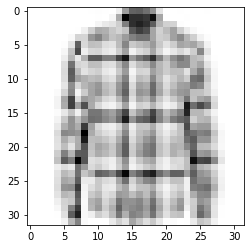

In [36]:
plt.imshow(data_test[7][0].permute((1,2,0)), cmap="Greys")

In [37]:
dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

In [38]:
# model = models.mnist.LeNet5_dropout(0, n_channels=1).to(device)

# model_dropout = models.mnist.LeNet5_dropout(.2).to(device)

from torchensemble.utils import io
from torchensemble import VotingClassifier
model = torch.load("checkpoints/lenet-fmnist.pt")
model_dropout = torch.load("checkpoints/lenet-fmnist-dropout0.2.pt")
model_ensemble = VotingClassifier(models.mnist.LeNet5(), 5)
io.load(model_ensemble, "checkpoints")


from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model, device)
scaled_model.set_temperature(data_loader_val)

# model_dropout = torch.load("models/fmnist_lenet_0.5dropout_all")
# model_dropout.load_state_dict(model.state_dict())
# model = model_dropout
# utils.mc_dropout.set_dropout_p(model, model, .03)
# model.feature_extractor[9] = torch.nn.Dropout2d(p=0.03)


# model_dropout = torch.load("models/fmnist_lenet_0.5dropout_all")

Before temperature - NLL: 0.297, ECE: 0.026
Optimal temperature: 1.324
After temperature - NLL: 0.289, ECE: 0.013


ModelWithTemperature(
  (model): LeNet5_dropout(
    (feature_extractor): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): Tanh()
      (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): Tanh()
      (5): Dropout2d(p=0, inplace=False)
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
      (8): Tanh()
      (9): Dropout2d(p=0, inplace=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=120, out_features=84, bias=True)
      (1): Dropout(p=0, inplace=False)
      (2): Tanh()
      (3): Linear(in_features=84, out_features=10, bias=True)
    )
  )
)

In [14]:
# model = models.mnist.LeNet5_dropout(p_dropout=0).to(device)
# print(model)
# optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()
# utils.model.train_model(
#     model, 20, optimizer, criterion, data_loaders, device, "checkpoints/lenet-fmnist.pt")

# utils.model.train_model(
#     model_dropout, 20, optimizer, criterion, data_loaders, device, "checkpoints/lenet-fmnist-dropout0.2.pt")

Epoch 1/20
----------
train Loss: 0.57 Acc: 0.79 Avg. conf: 0.72 Avg. max. prob: 0.77
val Loss: 0.47 Acc: 0.83 Avg. conf: 0.80 Avg. max. prob: 0.83
Checkpoint with val_loss = 0.47 saved.
Epoch 2/20
----------
train Loss: 0.40 Acc: 0.85 Avg. conf: 0.82 Avg. max. prob: 0.85
val Loss: 0.41 Acc: 0.84 Avg. conf: 0.82 Avg. max. prob: 0.85
Checkpoint with val_loss = 0.41 saved.
Epoch 3/20
----------
train Loss: 0.35 Acc: 0.87 Avg. conf: 0.84 Avg. max. prob: 0.87
val Loss: 0.38 Acc: 0.86 Avg. conf: 0.83 Avg. max. prob: 0.86
Checkpoint with val_loss = 0.38 saved.
Epoch 4/20
----------
train Loss: 0.32 Acc: 0.88 Avg. conf: 0.86 Avg. max. prob: 0.88
val Loss: 0.35 Acc: 0.88 Avg. conf: 0.85 Avg. max. prob: 0.88
Checkpoint with val_loss = 0.35 saved.
Epoch 5/20
----------
train Loss: 0.30 Acc: 0.89 Avg. conf: 0.87 Avg. max. prob: 0.89
val Loss: 0.35 Acc: 0.87 Avg. conf: 0.86 Avg. max. prob: 0.88
Epoch 6/20
----------
train Loss: 0.28 Acc: 0.90 Avg. conf: 0.87 Avg. max. prob: 0.90
val Loss: 0.34 Acc

In [39]:
utils.mc_dropout.set_dropout_p(model, model, .15)
progress_model= utils.model.run_validation(
    model, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=20)

progress_model_dropout = utils.model.run_validation(
    model_dropout, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=20)

progress_model_scaled = utils.model.run_validation(
    model_dropout, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=0)

progress_model_ensemble = utils.model.run_validation(
    model_ensemble, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=0)



Avg. acc.: 90.20: 100%|██████████| 313/313 [00:03<00:00, 80.56it/s]


In [11]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

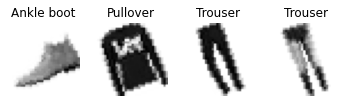

In [93]:
# incorrect = np.argwhere((progress_model.predictions != progress_model.labels) & (progress_model.max_probs > .9)).ravel()
# idx = np.argsort(progress_model.max_probs)[::-1][incorrect]
# idx=incorrect
num = 4
fig, axs = plt.subplots(1, num)
# dropout_max_probs_untrained = progress_model.dropout_outputs.max(axis=-1)

for i in range(num):
    axs[i].imshow(data_test[i][0].permute(1,2,0), cmap="Greys")
    # axs[i].set_title(
    #     f"Softmax: {progress_model.max_probs[idx[i]]:.2f}\n"
    #     f"MCD: {dropout_max_probs_untrained[idx[i]]:.2f}\n"
    #     f"Predicted: {class_names[int(progress_model.predictions[idx[i]])]}\n"
    #     f"Actual: {class_names[int(progress_model.labels[idx[i]])]}\n"
    # )
    axs[i].set_title(
        f"{class_names[int(data_test[i][1])]}"
    )
    axs[i].axis("off")

plt.savefig("fmnist-rotation-examples.pdf")

# progress_model.max_probs[ids]


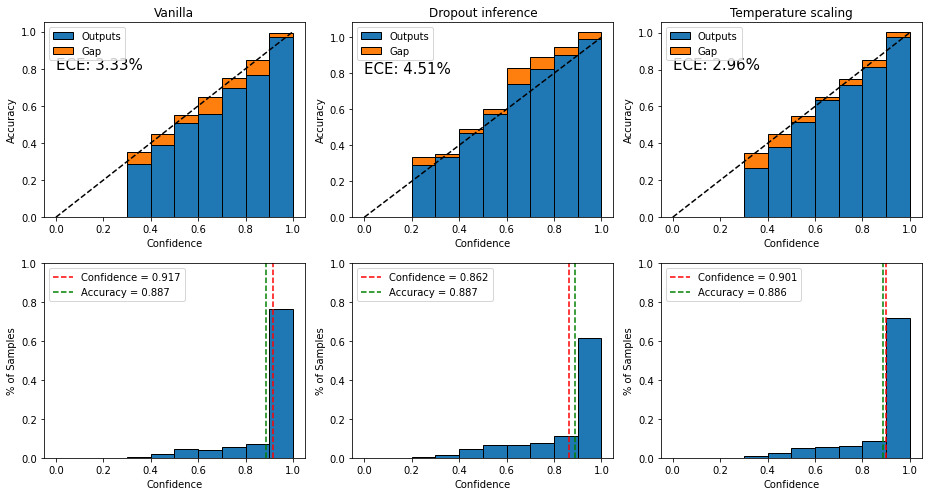

In [40]:
# nll = criterion(torch.tensor(progress.logits), torch.tensor(
#     progress.labels, dtype=torch.long)).item()
# print(
#     f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
#     f"NLL: {nll:4f}"
# )

# mc_logits = progress.dropout_logits.mean(axis=0)



ensemble_max_probs = progress_model_ensemble.logits.max(axis=1)

utils.visualisations.calibration_graph([
        ("Vanilla", progress_model.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions),
        ("Dropout inference", progress_model.dropout_max_probs, np.argsort(progress_model.dropout_max_probs), progress_model.dropout_predictions),
        ("Temperature scaling", progress_model_scaled.max_probs, np.argsort(progress_model_scaled.max_probs), progress_model_scaled.predictions),
    
    ],
    progress_model_dropout.labels, figsize=(13,7)
    )

plt.savefig("figures/fmnist-calibration1.pdf")

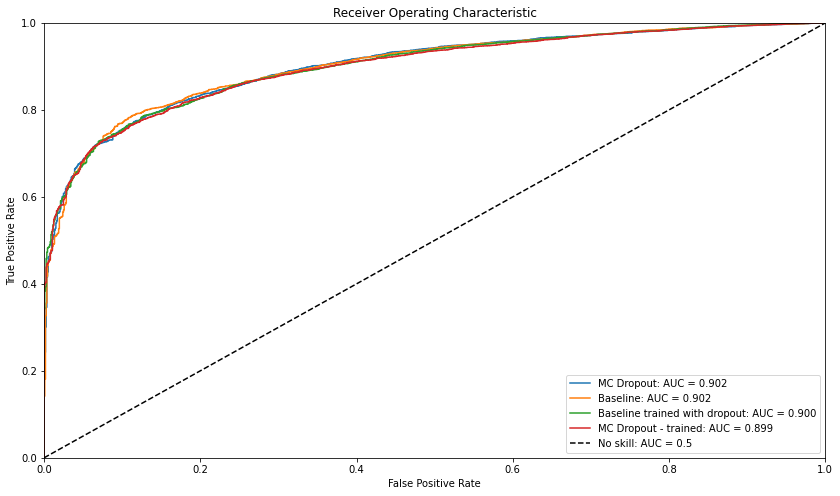

In [41]:
curves = []



correct = progress_model.dropout_predictions == progress_model.labels
max_probs = progress_model.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout"))

correct = progress_model.predictions == progress_model.labels
max_probs = progress_model.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline"))

correct = progress_model_dropout.predictions == progress_model.labels
max_probs = progress_model_dropout.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline trained with dropout"))

correct = progress_model_dropout.dropout_predictions == progress_model.labels
max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout - trained"))




plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
curves = {
    "mcd": utils.metrics.model_metrics(),
    "baseline": utils.metrics.model_metrics(),
    "baseline_dropout": utils.metrics.model_metrics(),
    "mcd_trained":utils.metrics.model_metrics(),
    "temp_scaling":utils.metrics.model_metrics(),
    "ensemble":utils.metrics.model_metrics(),

}




for s in np.arange(0, 65, 5):
    transforms= torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((32, 32)),
            torchvision.transforms.RandomRotation(degrees=(s,s)),
            torchvision.transforms.ToTensor(),
        ])

    data_test = torchvision.datasets.FashionMNIST(
        "fmnist", download=True, train=False, transform=transforms)
    data_loader_test = torch.utils.data.DataLoader(data_test,
                                                batch_size=32,
                                                shuffle=False)
    

    print(f"Strength: {s}")
    progress_model= utils.model.run_validation(
        model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)

    progress_model_dropout = utils.model.run_validation(
        model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)

    progress_model_scaled = utils.model.run_validation(
        scaled_model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)

    progress_model_ensemble = utils.model.run_validation(
        model_ensemble, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)


    # dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
    # trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)

    bins = np.linspace(0.05, 0.95, num=10)
    labels = progress_model.labels



    max_probs = progress_model.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model, progress_model.dropout_outputs, max_probs, progress_model.dropout_predictions, labels, bins, curves["mcd"], s)
    
    max_probs = progress_model.max_probs
    utils.metrics.update_model_metrics(progress_model, progress_model.probs, max_probs, progress_model.predictions, labels, bins, curves["baseline"], s)

    max_probs = progress_model_dropout.max_probs
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.probs, max_probs, progress_model_dropout.predictions, labels, bins, curves["baseline_dropout"], s)

    max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.dropout_outputs, max_probs, progress_model_dropout.dropout_predictions, labels, bins, curves["mcd_trained"], s)

    max_probs = progress_model_scaled.max_probs
    utils.metrics.update_model_metrics(progress_model_scaled, progress_model_scaled.probs, max_probs, progress_model_scaled.predictions, labels, bins, curves["temp_scaling"], s)

    max_probs = progress_model_ensemble.logits.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model_ensemble, progress_model_ensemble.logits, max_probs, progress_model_ensemble.predictions, labels, bins, curves["ensemble"], s)

Strength: 0


Avg. acc.: 90.20: 100%|██████████| 313/313 [00:03<00:00, 81.43it/s]


Strength: 5


Avg. acc.: 88.53: 100%|██████████| 313/313 [00:04<00:00, 73.84it/s]


Strength: 10


Avg. acc.: 79.35: 100%|██████████| 313/313 [00:04<00:00, 76.98it/s]


Strength: 15


Avg. acc.: 62.15: 100%|██████████| 313/313 [00:04<00:00, 74.83it/s]


Strength: 20


Avg. acc.: 50.72: 100%|██████████| 313/313 [00:04<00:00, 74.94it/s]


Strength: 25


Avg. acc.: 41.70: 100%|██████████| 313/313 [00:04<00:00, 76.68it/s]


Strength: 30


Avg. acc.: 31.47: 100%|██████████| 313/313 [00:04<00:00, 75.15it/s]


Strength: 35


Avg. acc.: 27.19: 100%|██████████| 313/313 [00:04<00:00, 74.54it/s]


Strength: 40


Avg. acc.: 23.04: 100%|██████████| 313/313 [00:04<00:00, 72.87it/s]


Strength: 45


Avg. acc.: 18.96: 100%|██████████| 313/313 [00:04<00:00, 73.01it/s]


Strength: 50


Avg. acc.: 17.10: 100%|██████████| 313/313 [00:04<00:00, 76.20it/s]


Strength: 55


Avg. acc.: 14.58: 100%|██████████| 313/313 [00:04<00:00, 73.84it/s]


Strength: 60


Avg. acc.: 12.58: 100%|██████████| 313/313 [00:04<00:00, 74.92it/s]


In [49]:
import pickle
with open("experiments/rotation_fmnist.pickle", "wb") as f:
    pickle.dump(curves,f)

In [13]:
import pickle
with open("experiments/rotation_fmnist.pickle", "rb") as f:
    curves = pickle.load(f)

In [51]:
print(df.to_latex(columns=["label", "acc", "ece", "confs", "brier", "auroc", "aupr"], float_format="%.3f"))

\begin{tabular}{llrrrrrr}
\toprule
{} &                label &   acc &   ece &  confs &  brier &  auroc &  aupr \\
\midrule
0 &              Vanilla & 0.887 & 3.330 &  0.917 &  0.016 &  0.902 & 0.986 \\
1 &    Dropout inference & 0.889 & 4.643 &  0.861 &  0.016 &  0.900 & 0.986 \\
2 &  Temperature scaling & 0.887 & 2.787 &  0.887 &  0.016 &  0.903 & 0.987 \\
3 &     Dropout training & 0.886 & 2.956 &  0.901 &  0.016 &  0.900 & 0.986 \\
4 &           MC Dropout & 0.885 & 4.007 &  0.869 &  0.016 &  0.903 & 0.987 \\
5 &             Ensemble & 0.902 & 2.834 &  0.910 &  0.014 &  0.908 & 0.989 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1096882/1171662097.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(columns=["label", "acc", "ece", "confs", "brier", "auroc", "aupr"], float_format="%.3f"))


In [48]:
import pandas as pd
df = pd.DataFrame()

for label, prog in curves.items():
    print(label)
    row = {"label":label}

    for name,val in vars(prog).items():
        if len(val)>0:
            row[name] = val[0]
            print(name, val[0])
    df=df.append(row,ignore_index=True)
df

Vanilla
acc 0.8874
ece 3.3299999999999987
confs 0.9173602181732654
brier 0.016149578340527562
auroc 0.9021427480438184
aupr 0.9863897175396295
strengths 0
Dropout inference
acc 0.8892
ece 4.6430000000000025
confs 0.86128944
brier 0.016076240927596023
auroc 0.8997492574349879
aupr 0.9864904253649456
strengths 0
Temperature scaling
acc 0.8872
ece 2.786500000000006
confs 0.8868275027170778
brier 0.01585198304017558
auroc 0.9029461533646322
aupr 0.9865008422558432
strengths 0
Dropout training
acc 0.886
ece 2.9564999999999997
confs 0.9011754695236683
brier 0.016327488368792893
auroc 0.9003669392437826
aupr 0.9862057253991718
strengths 0
MC Dropout
acc 0.8849
ece 4.0070000000000014
confs 0.8690295
brier 0.016305515312748615
auroc 0.9031949331082485
aupr 0.986532965976684
strengths 0
Ensemble
acc 0.9019
ece 2.8339999999999996
confs 0.9101205
brier 0.014162517541390645
auroc 0.9080740644373049
aupr 0.9892340644173011
strengths 0


/tmp/ipykernel_1096882/529230776.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1096882/529230776.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1096882/529230776.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1096882/529230776.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1096882/529230776.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

,label,acc,ece,confs,brier,auroc,aupr,strengths
0,Vanilla,0.8874,3.3300,0.917360,0.016150,0.902143,0.986390,0
1,Dropout inference,0.8892,4.6430,0.861289,0.016076,0.899749,0.986490,0
2,Temperature scaling,0.8872,2.7865,0.886828,0.015852,0.902946,0.986501,0
3,Dropout training,0.8860,2.9565,0.901175,0.016327,0.900367,0.986206,0
4,MC Dropout,0.8849,4.0070,0.869030,0.016306,0.903195,0.986533,0
5,Ensemble,0.9019,2.8340,0.910120,0.014163,0.908074,0.989234,0


In [45]:
curves["Vanilla"] = curves["baseline"]
curves["Dropout inference"] = curves["mcd"]
curves["Temperature scaling"] = curves["temp_scaling"]
curves["Dropout training"] = curves["baseline_dropout"]
curves["MC Dropout"] = curves["mcd_trained"]
curves["Ensemble"] = curves["ensemble"] 

del curves['baseline']
del curves['mcd']
del curves['temp_scaling']
del curves['baseline_dropout']
del curves['mcd_trained']
del curves['ensemble']


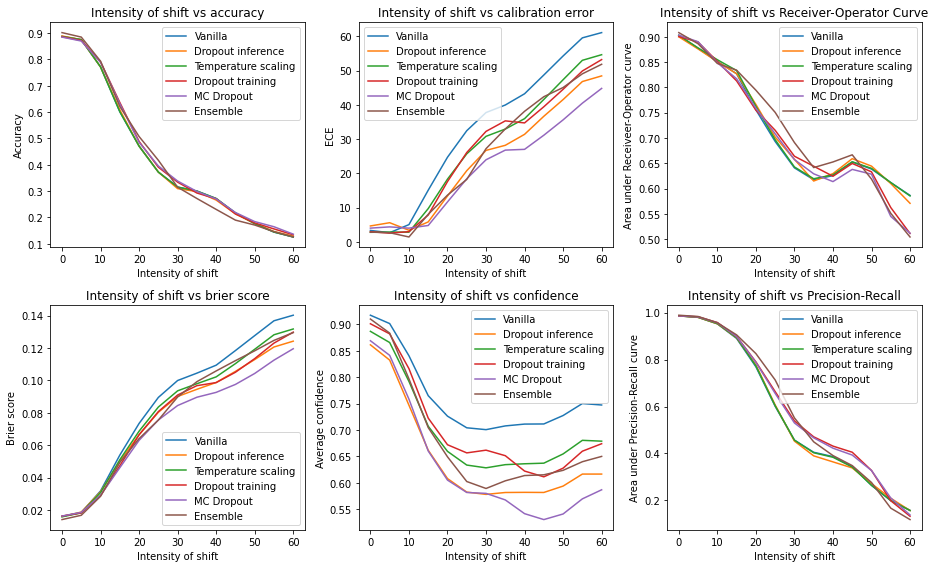

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(13, 8))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.acc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs accuracy")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Accuracy")

    ax = axs[1][0]
    ax.plot(m.strengths, m.brier, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs brier score")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Brier score")

    ax = axs[0][1]
    ax.plot(m.strengths, m.ece, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs calibration error")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("ECE")

    ax = axs[1][1]
    ax.plot(m.strengths, m.confs, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs confidence")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][2]
    ax.plot(m.strengths, m.auroc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs Receiver-Operator Curve")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Receiveer-Operator curve")

    ax = axs[1][2]
    ax.plot(m.strengths, m.aupr, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs Precision-Recall")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Precision-Recall curve")
fig.tight_layout()

plt.savefig("figures/fmnist-rotation.pdf")

In [68]:
transforms= torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.RandomRotation(degrees=(40,40)),
        torchvision.transforms.ToTensor(),
    ])

data_test = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=False, transform=transforms)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                            batch_size=32,
                                            shuffle=False)

progress_model = utils.model.run_validation(
    model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=5)
progress_model_dropout = utils.model.run_validation(
    model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=5)




Avg. acc.: 26.16: 100%|██████████| 313/313 [00:02<00:00, 139.94it/s]


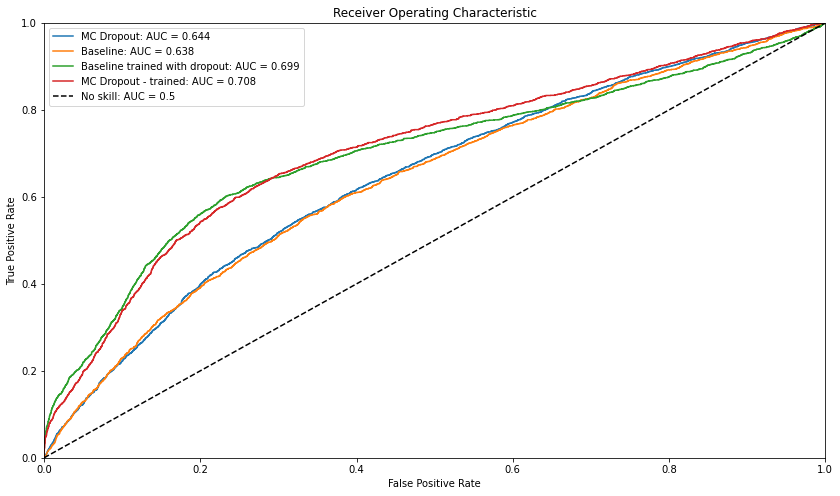

In [70]:
curves = []



correct = progress_model.dropout_predictions == progress_model.labels
max_probs = progress_model.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout"))

correct = progress_model.predictions == progress_model.labels
max_probs = progress_model.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline"))

correct = progress_model_dropout.predictions == progress_model.labels
max_probs = progress_model_dropout.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline trained with dropout"))

correct = progress_model_dropout.dropout_predictions == progress_model.labels
max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout - trained"))




plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

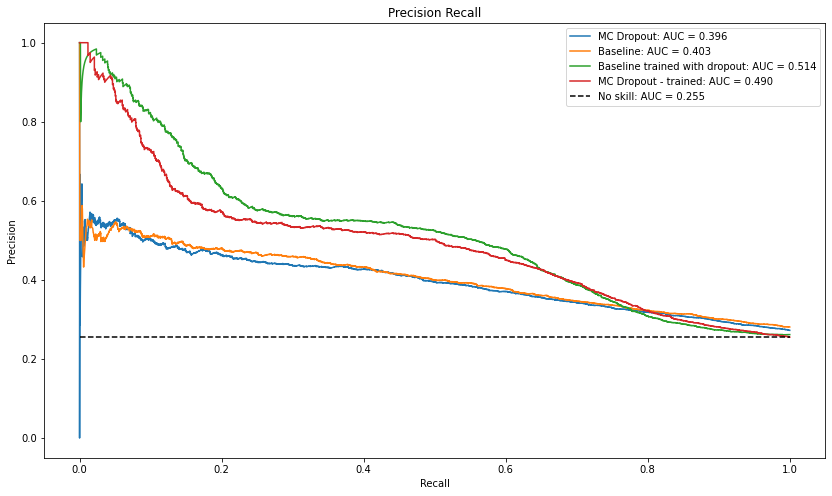

In [71]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14,8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k", linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()